In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [21]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [22]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [23]:
# Set up device
device = (
    "cuda:1"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda:1 device NVIDIA TITAN V


In [24]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
#n_data = [500, 1000, 2000, 3000, 5000]
patience = 70
load_ensemble_values = True

#Data constants
shapes = [2, 2]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes
grid_rmax=20

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [25]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

In [26]:
model = SequentialNet(L=200, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
#model = SequentialNet(L=5000, n_hidden=4, activation="relu", in_channels=2, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model # Check that everything looks good

SequentialNet(
  (hidden_layers): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
  )
  (first_layer): Linear(in_features=2, out_features=200, bias=True)
  (last_layer): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

100%|██████████| 100/100 [00:00<00:00, 571.81it/s]


Text(0.5, 0.98, 'Number of training datapoints: 0')

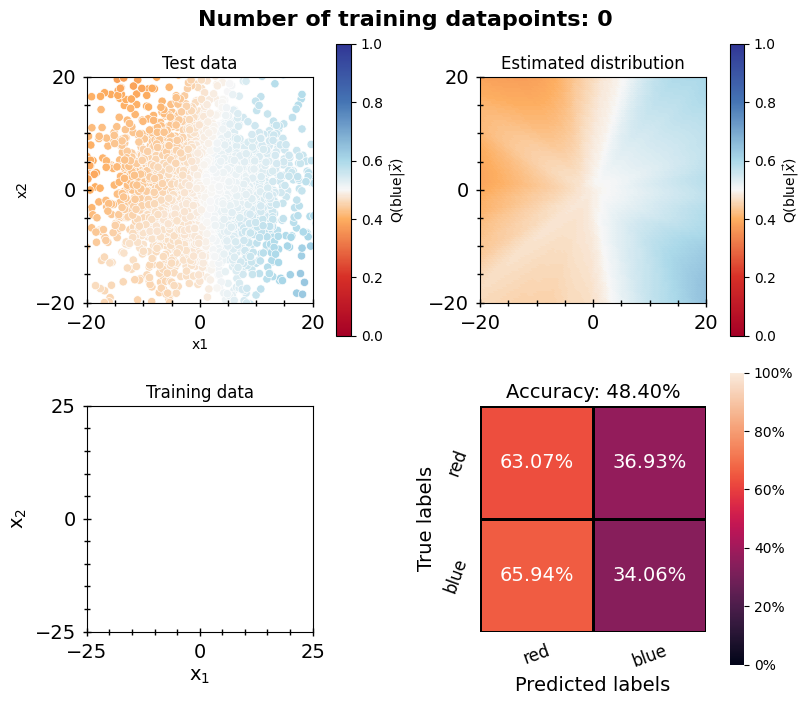

In [27]:
truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
val_data["Prediction"] = torch.argmax(logits_val, dim=-1).flatten()
val_data["Confidence"] = torch.softmax(logits_val, dim=-1)[:,1] #Get softmax score for blue

truth_grid, logits_grid = predict_classifier(model, grid_dataset, 2, 100, device)
grid_data["Prediction"] = torch.argmax(logits_grid, dim=-1).flatten()
grid_data["Confidence"] = torch.softmax(logits_grid, dim=-1)[:,1] #Get softmax score for blue

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test data", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Confidence", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(val_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:0], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: 0", size=16, fontweight="bold")

2048


 63%|██████▎   | 63/100 [02:11<01:17,  2.08s/it]


Stopping training early at epoch 63


100%|██████████| 50/50 [00:00<00:00, 525.27it/s]


<Axes: xlabel='Iteration'>

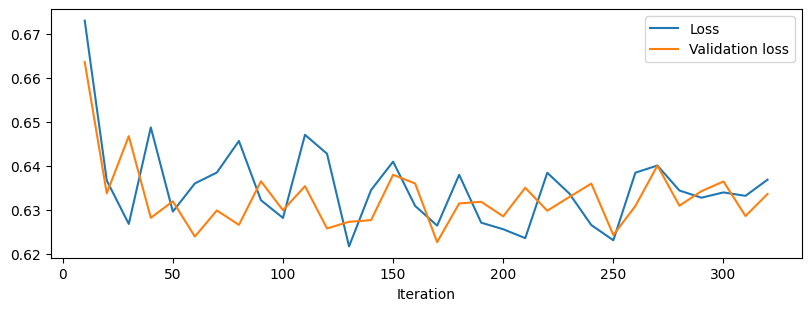

In [28]:
n_train = 10000
patience = 30
epochs = 100
lr = 0.01
batchsize = 2**11
print(batchsize)

train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
training_results = train_classifier(model, train_dataset, 
                         val_dataset, batchsize=batchsize, epochs = 100, 
                         device = device, optimizer = optimizer, early_stopping=patience)
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs)

100%|██████████| 100/100 [00:00<00:00, 512.60it/s]


Text(0.5, 0.98, 'Number of training datapoints: 10000')

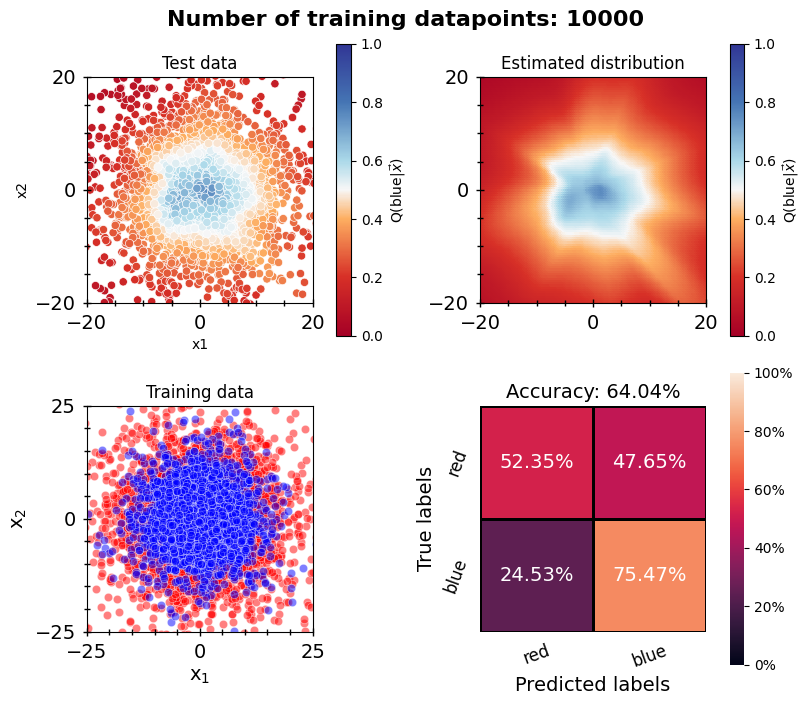

In [29]:
truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
val_data["Prediction"] = torch.argmax(logits_val, dim=-1).flatten()
val_data["Confidence"] = torch.softmax(logits_val, dim=-1)[:,1] #Get softmax score for blue

truth_grid, logits_grid = predict_classifier(model, grid_dataset, 2, 100, device)
grid_data["Prediction"] = torch.argmax(logits_grid, dim=-1).flatten()
grid_data["Confidence"] = torch.softmax(logits_grid, dim=-1)[:,1] #Get softmax score for blue

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test data", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Confidence", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(val_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:n_train], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")


<Axes: xlabel='r', ylabel='Count'>

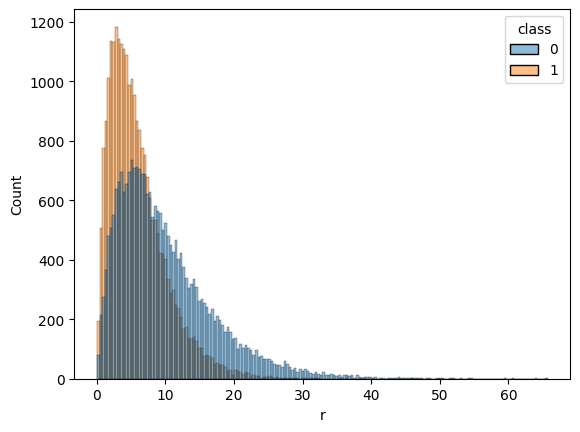

In [30]:
sn.histplot(train_data, x="r", hue="class")

Estimated maximum accuracy: 0.6282148182950994


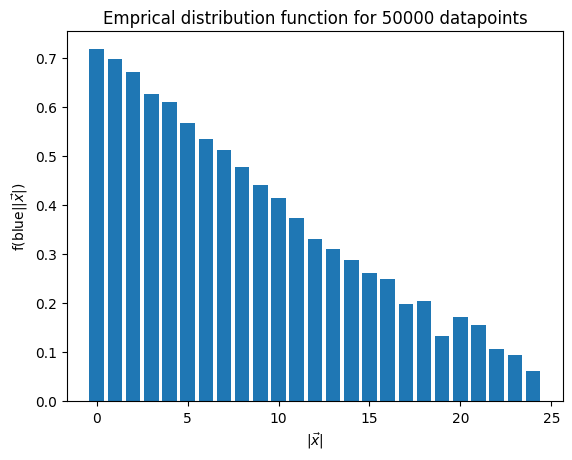

In [31]:
red_rx = train_data[train_data["class"] == 0]["r"].values
blue_rx = train_data[train_data["class"] == 1]["r"].values
red_count, red_bins = np.histogram(red_rx, bins=25, range=(0, 25))
blue_count, blue_bins = np.histogram(blue_rx, bins=25, range=(0, 25))
fraction_blue = np.array([(blue_count[i])/(red_count[i]+blue_count[i]) for i in range(len(red_count))])
fraction_red = 1 - fraction_blue
plt.bar(red_bins[0:-1], fraction_blue)
plt.title(f"Emprical distribution function for {len(train_data)} datapoints")
plt.xlabel(r"$|\vec{x}|$")
plt.ylabel(r"f(blue||$\vec{x}$|)")
acc = np.array([max(fraction_blue[i], fraction_red[i])*(red_count[i]+blue_count[i])/sum(red_count + blue_count) for i in range(len(red_count))])
max_acc = sum(acc[~np.isnan(acc)])
print(f"Estimated maximum accuracy: {max_acc}")

(0.0, 1.0)

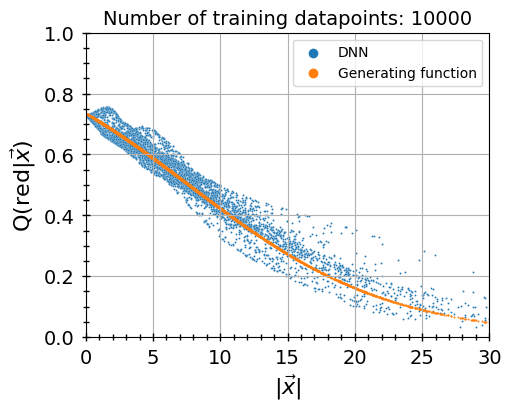

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5, 4), layout="constrained")
sn.scatterplot(val_data, x="r", y="Confidence", s=2, ax = ax, label ="DNN")
sn.scatterplot(val_data, x="r", y="p_c1_given_r", s=2, ax = ax, label="Generating function", linewidth=0)
#ax.plot(red_bins[0:-1], fraction_blue, label="Empirical estimated distribution", color="red")
ax.set_title(f"Number of training datapoints: {n_train}", fontsize=14)
ax.legend(markerscale=5, fontsize=10)
ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
ax.set_ylabel(r"Q(red|$\vec{x}$)", fontsize=16)
ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
ax.tick_params(which="major", length=6)
ax.minorticks_on()
ax.grid()
ax.set_xlim(0, 30)
ax.set_ylim(0, 1)

Text(0.5, 0.98, 'Number of training datapoints: 10000')

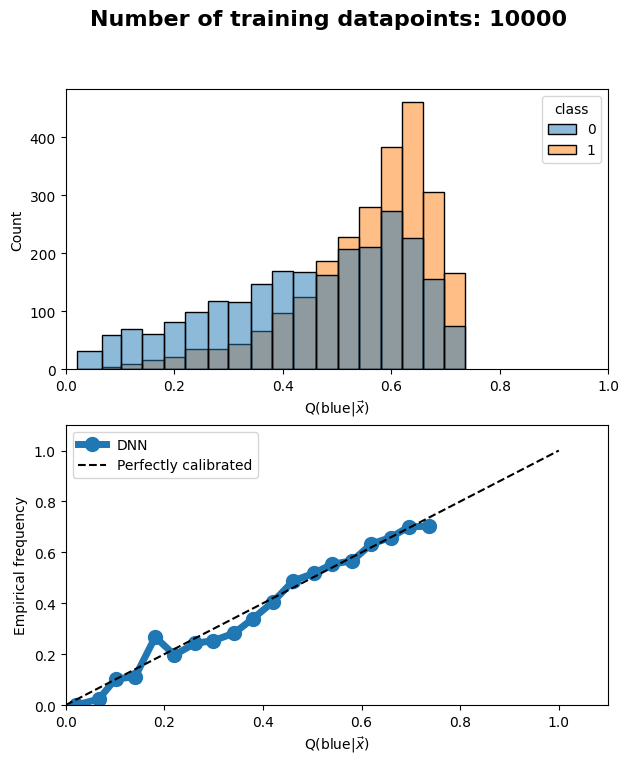

In [33]:
prob_cal, prob_pred = calibration_curve(val_data["class"], val_data["Confidence"], n_bins=25, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
sn.histplot(val_data, x="Confidence", hue="class", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[0].set_xlabel(r"Q(blue|$\vec{x}$)")
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
ax[1].set_ylabel("Empirical frequency")
ax[1].legend()
fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")